In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time
import pickle

from datetime import datetime
from pathlib import Path

import math 


#### Import classes

In [2]:
%run "custom_datasets.ipynb"
%run "Model Classes/cnn_model.ipynb"
%run "Model Classes/siren_model.ipynb"

Imported classes.
Imported CNN model.
Imported SIREN model.


In [3]:
def set_device():
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('----------------------------------')
    print('Using device for training:', DEVICE)
    print('----------------------------------')
    
    return DEVICE 

DEVICE = set_device()
# DEVICE = torch.device('cpu')

----------------------------------
Using device for training: cuda
----------------------------------


#### Dataloader

In [4]:
data = PrepareData3D(["Aorta Volunteers", "Aorta BaV", "Aorta Resvcue", "Aorta CoA"], norm_min_max=[0,1])

train_ds = SirenDataset(data.train, DEVICE) 
train_dataloader = DataLoader(train_ds, batch_size=1, num_workers=0)
print(train_ds.__len__())


val_ds = SirenDataset(data.val, DEVICE) 
val_dataloader = DataLoader(val_ds, batch_size=1, num_workers=0)
print(val_ds.__len__())


1
1


#### Load models

In [5]:
cnn = CNN().cuda()

In [6]:
siren = Siren(in_features=131, out_features=1, hidden_features=256, 
              hidden_layers=4, first_different_init=True, 
              outermost_layer="sigmoid").cuda()

#### Optimizers & Loss

In [7]:
lr = 2e-4

siren_optim = torch.optim.Adam(lr=lr, params=siren.parameters())
cnn_optim = torch.optim.Adam(lr=lr, params=cnn.parameters())

# def l2_loss(out, ground_truth): 
#     return ((out - ground_truth)**2).mean()

# criterion = l2_loss

criterion = nn.BCELoss()

#####  Random coords subsample

In [8]:
def choose_random_coords(coords, pcmra_array, mask_array, n=1000): 
    mx = coords.shape[1]
    rand_idx = random.sample(range(mx), n)

    coords = coords[:, rand_idx, :]
    pcmra_array = pcmra_array[:, rand_idx, :]
    mask_array = mask_array[:, rand_idx, :]

    return coords, pcmra_array, mask_array

#### Image generation and model saving functions 

In [9]:
def get_complete_image(pcmra, coords, val_n = 10000): 
    
    cnn.eval()
    siren.eval()
    
    image = torch.Tensor([]).cuda()
    
    cnn_out = cnn(pcmra)
    
    n_slices = math.ceil(coords.shape[1] / val_n)    
    for i in range(n_slices):
        s_e = (i * val_n, (i+1) * val_n)
        
        coords_in = coords[:, s_e[0] : s_e[1], :]
        z = cnn_out.unsqueeze(0).repeat(1, coords_in.shape[1], 1)
        siren_in = torch.cat((coords_in, z), 2)

        siren_out = siren(siren_in)
    
        image = torch.cat((image, siren_out.detach()), 1)
    
    cnn.train()
    cnn.train()
    
    return image 


def save_model(best_loss, losses, dataset="train"):
    mean, std = round(np.mean(losses), 6), round(np.std(losses), 6)

    print(f"{dataset} \t mean loss: {mean} \t std: {std}")

    if mean < best_loss: 
        best_loss = mean
        print(f"New best {dataset} loss, saving model.")

        torch.save(cnn.state_dict(), f"Models/{folder}/cnn_{dataset}.pt")
        torch.save(siren.state_dict(), f"Models/{folder}/siren_{dataset}.pt")

    return best_loss     

#### Alter optimizers

In [10]:
# lr = 1e-3
# cnn_optim.param_groups[0]['lr'] = lr
# siren_optim.param_groups[0]['lr'] = lr


#### Train model
for pcmra array with linear output, 0.000500 is good
for mask with sigmoid output and BCE, 0.02 is good. 

In [13]:
epochs = 500
print_every = 10

# n = 393216
n = 30000

output_type = "mask"
dataset = "complete"

now = datetime.now()
dt = now.strftime("%d-%m-%Y %H:%M:%S")

folder = f"{dt} {output_type}_{dataset} dataset_lr {lr}_n {n}"

Path(f"Models/{folder}").mkdir(parents=True, exist_ok=True)   
print(f"Creating path \\Models\\{folder}")
    

best_train_loss, best_val_loss = 100000, 100000

for ep in range(epochs):
    
    t = time.time() 
    
    cnn.train()
    siren.train()

    losses = []
    
    siren_optim.zero_grad()
    cnn_optim.zero_grad()
        
    for idx, subj, proj, pcmra, coords, pcmra_array, mask_array in train_dataloader:
        siren_in, _, siren_labels = choose_random_coords(coords, pcmra_array, mask_array, n=n)

        cnn_out = cnn(pcmra)

        cnn_out = cnn_out.unsqueeze(0).repeat(1, n, 1)
        siren_in = torch.cat((siren_in, cnn_out), 2)

        siren_out = siren(siren_in)

        loss = criterion(siren_out, siren_labels) 
        losses.append(loss.item())
        
        loss = loss / train_ds.__len__()
        loss.backward()
    
    siren_optim.step()
    cnn_optim.step()        

    if ep % print_every == 0: 
        
        print(f"Epoch {ep} took {round(time.time() - t)} seconds.")
        
        best_train_loss = save_model(best_train_loss, losses, dataset="train")
        
        val_losses = []
        
        for idx, subj, proj, pcmra, coords, pcmra_array, mask_array in val_dataloader:    
            siren_out = get_complete_image(pcmra, coords)
            loss = criterion(siren_out, pcmra_array)            
        
            val_losses.append(loss.item())
            
        best_val_loss = save_model(best_val_loss, val_losses, dataset="val")
                
        print()
        

Creating path \Models\27-03-2021 10:59:59 
Epoch 0 took 0 seconds.
train 	 mean loss: 0.269065 	 std: 0.0
New best train loss, saving model.
val 	 mean loss: 0.338361 	 std: 0.0
New best val loss, saving model.

Epoch 10 took 0 seconds.
train 	 mean loss: 0.217049 	 std: 0.0
New best train loss, saving model.
val 	 mean loss: 0.319573 	 std: 0.0
New best val loss, saving model.

Epoch 20 took 0 seconds.
train 	 mean loss: 0.191845 	 std: 0.0
New best train loss, saving model.
val 	 mean loss: 0.284191 	 std: 0.0
New best val loss, saving model.

Epoch 30 took 0 seconds.
train 	 mean loss: 0.171796 	 std: 0.0
New best train loss, saving model.
val 	 mean loss: 0.275185 	 std: 0.0
New best val loss, saving model.

Epoch 40 took 0 seconds.
train 	 mean loss: 0.158582 	 std: 0.0
New best train loss, saving model.
val 	 mean loss: 0.273995 	 std: 0.0
New best val loss, saving model.

Epoch 50 took 0 seconds.
train 	 mean loss: 0.156853 	 std: 0.0
New best train loss, saving model.
val 	 mea

#### Show results

RESV_109.npy, loss: 0.01874643936753273


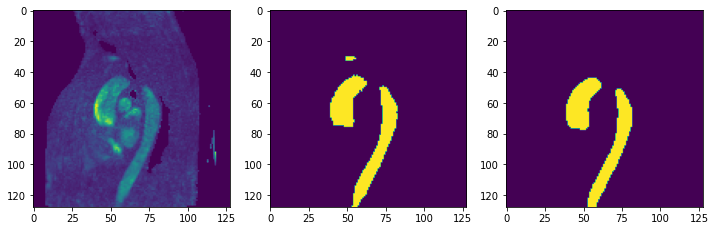

In [38]:
idx, subj, proj, pcmra, coords, pcmra_array, mask_array = train_ds[0]
pcmra, coords = pcmra.unsqueeze(0), coords.unsqueeze(0)
pcmra_array, mask_array =  pcmra_array.unsqueeze(0), mask_array.unsqueeze(0)

siren_out = get_complete_image(pcmra, coords)
loss = criterion(siren_out, mask_array)            

print(f"{subj}, loss: {loss}")

slic = 16

fig, axes = plt.subplots(1, 3, figsize=(12,12))
axes[0].imshow(pcmra_array.cpu().view(128, 128, 24).detach().numpy()[:, :, slic])
axes[1].imshow(mask_array.cpu().view(128, 128, 24).detach().numpy()[:, :, slic])
axes[2].imshow(siren_out.cpu().view(128, 128, 24).detach().numpy().round()[:, :, slic])

plt.show()

In [ ]:
for idx, subj, proj, pcmra, coords, pcmra_array, mask_array in val_dataloader: 
    
    print(subj) 
    
    siren_out = get_complete_image(pcmra, coords)
    loss = criterion(siren_out, pcmra_array)            

    slic = 12

    fig, axes = plt.subplots(1, 2, figsize=(12,12))
    axes[1].imshow(siren_out.cpu().view(128, 128, 24).detach().numpy()[:, :, slic])
    axes[0].imshow(pcmra_array.cpu().view(128, 128, 24).detach().numpy()[:, :, slic])

    plt.show()